# test.fa に対する結果の図示

In [47]:
import subprocess
import matplotlib.pyplot as plt

# 実行時変数
EXE = "..\\a.exe"
IN_FILE = "../../CapR/test.fa"
OUT_FILE = "../test/out.txt"

def run_command(beam_size):
	command_state = f"{EXE} {IN_FILE} {OUT_FILE} {beam_size}"
	cp = subprocess.run(command_state, shell=True, capture_output=True, text=True)
	print(cp.stdout)
	print(cp.stderr)

In [4]:
def parse_output(out_file):
	structures = []
	probs = []
	with open(out_file, "r") as f:
		seq_name = f.readline()[1:]
		print(seq_name)
		for line in f:
			data = line.split()
			if len(data) == 0: continue
			structures.append(data[0])
			probs.append(list(map(float, data[1:])))
	return structures, probs

In [2]:
def show_graph(s, p, x1, x2):
	for i in range(len(s)):
		plt.plot(range(len(p[i])), p[i], label=s[i])

	plt.xlabel("nucleotide position")
	plt.ylabel("probability")
	# plt.ylim(-0.1, 1.1)
	plt.xlim(x1, x2)
	plt.legend(bbox_to_anchor=(1, 1),loc="upper left",fontsize=12)
	plt.show()

In [35]:
run_command(0)


URS0000ABD7E8 rRNA from 1 species



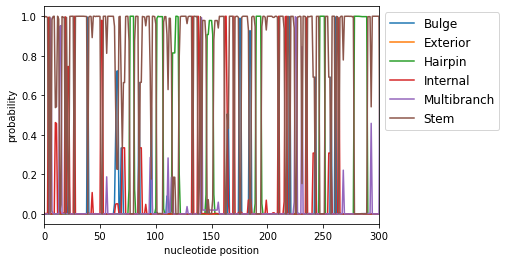

In [48]:
s, p = parse_output("../../dataset/out_LinearCapR/test_short_5.out")
show_graph(s, p, 0, 300)

In [49]:
res = ""
for i in range(len(p)):
	for j in range(len(p[0])):
		if p[i][j] < -0.1:
			res += f"{i}, {j}: {p[i][j]:10.6f}\n"
print(res)

URS0000ABD7E8 rRNA from 1 species



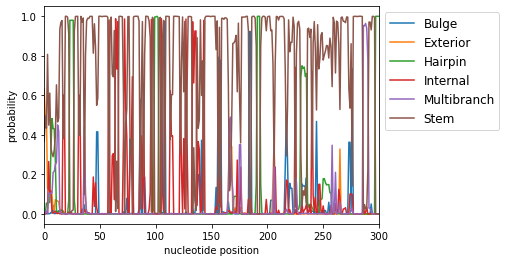

In [41]:
s, p = parse_output("../../dataset/out_CapR/out_short_200.txt")
show_graph(s, p, 0, 300)

In [ ]:
beam = [5, 10, 20, 30, 40, 50, 100, 0]
for b in beam:
	run_command(b)
	print(b)
	s, p = parse_output(OUT_FILE)
	x = []
	for i in range(len(p[0])):
		p_sum = 0
		for j in range(len(s)):
			p_sum += p[j][i]
		x.append(p_sum)
	print(x)

	